In [8]:
# Import libraries for sound and display
import pandas as pd
import numpy as np
from os.path import join as pjoin
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns

# Import libraries for ML
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers as L

Load the data

In [9]:
Cries = pd.read_csv("cries_8.csv")
Cries_test = pd.read_csv("cries_8_test.csv")
print(Cries.shape)
Cries.head()

(1320, 80)


,tempo,beat_mean,beat_var,harm_mean,harm_var,perc_mean,perc_var,specen_mean_0,specen_var_0,mfcc_mean_0,...,chroma_var_9,chroma_mean_10,chroma_var_10,chroma_mean_11,chroma_var_11,rms_mean_0,rms_var_0,zcr_mean_0,zcr_var_0,Labels
0,83.705357,27.500000,12.250000,-0.000002,0.000309,0.000002,0.068899,1064.999328,514939.655595,-241.350769,...,0.152273,0.253239,0.104412,0.130955,0.028916,0.199852,0.032550,0.409202,0.086321,hungry
1,83.705357,17.000000,98.000000,0.000082,0.000561,0.000151,0.068904,1406.915699,19750.350392,-37.452045,...,0.102001,0.487648,0.107184,0.424836,0.136082,0.210326,0.029129,0.566857,0.008820,hungry
2,117.187500,29.500000,6.250000,-0.000002,0.000629,0.000004,0.031519,1217.543918,456525.253056,-268.593353,...,0.143556,0.386409,0.131537,0.241106,0.062973,0.142998,0.015818,0.458368,0.082611,hungry
3,97.656250,17.333333,97.222222,0.000048,0.000882,0.000056,0.031565,1427.955094,22533.085803,-41.222751,...,0.072566,0.655430,0.080964,0.547177,0.097843,0.153713,0.013533,0.587290,0.009306,hungry
4,83.705357,27.500000,12.250000,-0.000002,0.000309,0.000002,0.068899,1064.999328,514939.655595,-241.350769,...,0.152273,0.253239,0.104412,0.130955,0.028916,0.199852,0.032550,0.409202,0.086321,hungry


Data preparation

In [10]:
# Take all rows and cols without last col for X which include features
X = Cries.iloc[:, :-1].values
X_test = Cries_test.iloc[:, :-1].values
# Take last col for Y, which include the cry labels
Y = Cries["Labels"].values
Y_test = Cries_test["Labels"].values


# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
Y_test = encoder.fit_transform(np.array(Y_test).reshape(-1, 1)).toarray()

x_train = X 
x_test = X_test 
y_train = Y
y_test = Y_test
#x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1320, 79) (1320, 5) (468, 79) (468, 5)


Reshape for lstm and scale for CNN model

In [11]:
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

scaler = StandardScaler()
x_train = np.expand_dims(scaler.fit_transform(x_train), axis=2)
x_test = np.expand_dims(scaler.transform(x_test), axis=2)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1320, 79, 1) (1320, 5) (468, 79, 1) (468, 5)


In [12]:
# Applying early stopping for all models
model_checkpoint = ModelCheckpoint("best_model_cnn_weights_features.h5", monitor="val_accuracy", save_best_only=True)

early_stop = EarlyStopping(monitor="val_accuracy", mode="auto", patience=8, restore_best_weights=False)
lr_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=8, verbose=1, factor=0.5, min_lr=0.0000001)


CNN model

In [13]:
model = tf.keras.Sequential([
    L.Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding="same"),
    L.Conv1D(512, kernel_size=5, strides=1, padding="same", activation="relu"),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=1, padding="same"),
    Dropout(0.2), # Add dropout layer after the second pooling layer
    L.Conv1D(256, kernel_size=5, strides=1, padding="same", activation="relu"),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=1, padding="same"),
    L.Conv1D(256, kernel_size=3, strides=1, padding="same", activation="relu"),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5, strides=2, padding="same"),
    Dropout(0.2), # Add dropout layer after the forth max pooling layer
    L.Conv1D(128, kernel_size=3, strides=1, padding="same", activation="relu"),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3, strides=2, padding="same"),
    Dropout(0.2), # Add dropout layer after the fifth max pooling layer
    L.Flatten(),
    L.Dense(512, activation="relu"),
    L.BatchNormalization(),
    L.Dense(5, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 79, 512)           3072      
                                                                 
 batch_normalization_6 (Bat  (None, 79, 512)           2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 40, 512)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 40, 512)           1311232   
                                                                 
 batch_normalization_7 (Bat  (None, 40, 512)           2048      
 chNormalization)                                                
                                                      

Train CNN model

In [14]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=20, callbacks=[early_stop, lr_reduction, model_checkpoint])

Epoch 1/50
66/66 [==============================] - 6s 19ms/step - loss: 0.9282 - accuracy: 0.6955 - val_loss: 1.9580 - val_accuracy: 0.1368 - lr: 0.0010
Epoch 2/50
 8/66 [==>...........................] - ETA: 0s - loss: 0.2764 - accuracy: 0.9125

/usr/lib/python3/dist-packages/keras/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 0s 7ms/step - loss: 0.2231 - accuracy: 0.9303 - val_loss: 3.2656 - val_accuracy: 0.1261 - lr: 0.0010
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0867 - accuracy: 0.9712 - val_loss: 3.5467 - val_accuracy: 0.2051 - lr: 0.0010
Epoch 4/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0782 - accuracy: 0.9780 - val_loss: 3.5767 - val_accuracy: 0.1709 - lr: 0.0010
Epoch 5/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0927 - accuracy: 0.9674 - val_loss: 5.5271 - val_accuracy: 0.1966 - lr: 0.0010
Epoch 6/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0716 - accuracy: 0.9697 - val_loss: 4.5946 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 7/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0363 - accuracy: 0.9879 - val_loss: 5.6538 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 8/50
66/66 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0

Plot performance

15/15 [==============================] - 0s 3ms/step - loss: 5.5455 - accuracy: 0.1282
Accuracy of our model on test data :  12.820513546466827 %


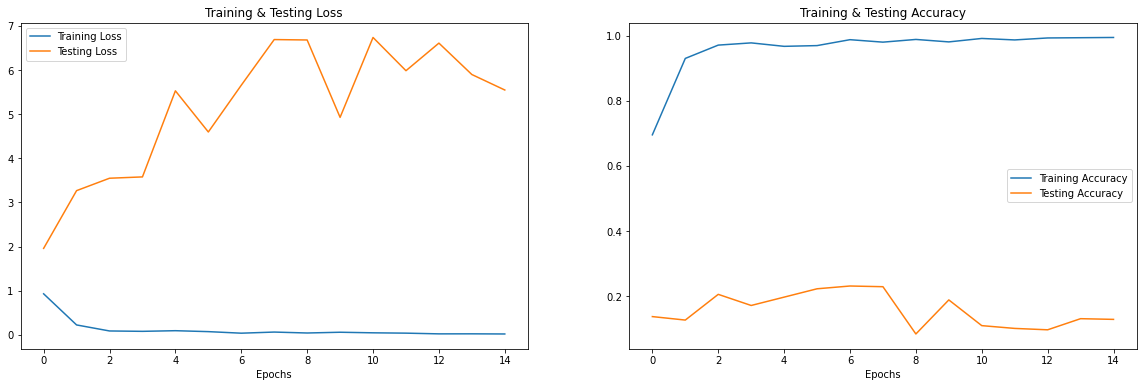

In [15]:
print("Accuracy of our model on test data : ", model.evaluate(x_test, y_test)[1]*100, "%")

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
test_acc = history.history["val_accuracy"]
test_loss = history.history["val_loss"]

epochs = [i for i in range(len(train_loss))]

fig.set_size_inches(20, 6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()



Predicting on test data

In [16]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test0 = encoder.inverse_transform(y_test)

df0 = pd.DataFrame(columns=["Predicted Labels", "Actual Labels"])
df0["Predicted Labels"] = y_pred.flatten()
df0["Actual Labels"] = y_test0.flatten()

df0.head(10)

15/15 [==============================] - 0s 2ms/step


,Predicted Labels,Actual Labels
0,tired,hungry
1,tired,hungry
2,tired,hungry
3,burping,hungry
4,tired,hungry
5,tired,hungry
6,tired,hungry
7,burping,hungry
8,tired,hungry
9,tired,hungry


Evaluation

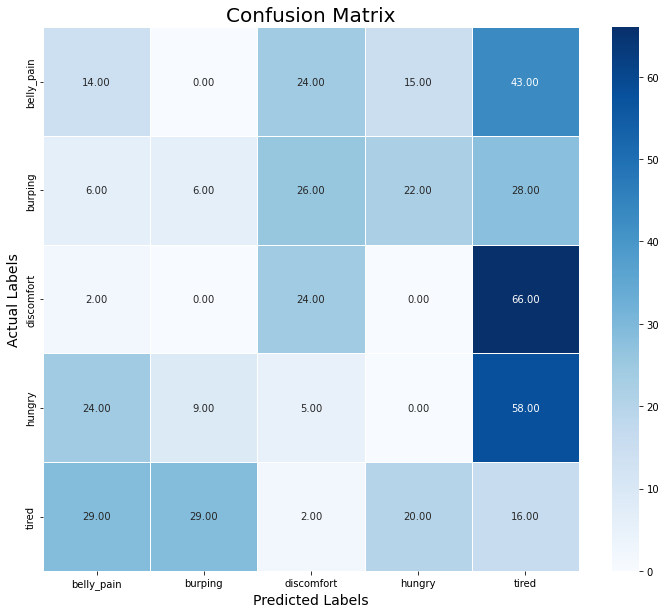

              precision    recall  f1-score   support

  belly_pain       0.19      0.15      0.16        96
     burping       0.14      0.07      0.09        88
  discomfort       0.30      0.26      0.28        92
      hungry       0.00      0.00      0.00        96
       tired       0.08      0.17      0.10        96

    accuracy                           0.13       468
   macro avg       0.14      0.13      0.13       468
weighted avg       0.14      0.13      0.13       468



In [17]:
cm = confusion_matrix(y_test0, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])

sns.heatmap(cm, linecolor="white", cmap="Blues", linewidths=1, annot=True, fmt=".2f")

plt.title("Confusion Matrix", size=20)
plt.xlabel("Predicted Labels", size=14)
plt.ylabel("Actual Labels", size=14)
plt.show()
print(classification_report(y_test0, y_pred))